In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.online_portfolio_selection.momentum import *
# import seaborn as sns
import optuna
from mlfinlab.portfolio_optimization import ReturnsEstimators
from mlfinlab.portfolio_optimization import HierarchicalRiskParity
from mlfinlab.online_portfolio_selection import FCORN
import dl_csv
from mlfinlab.portfolio_optimization.herc import HierarchicalEqualRiskContribution
from mlfinlab.online_portfolio_selection.benchmarks import *
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from pycoingecko import CoinGeckoAPI
from datetime import date, datetime
import ccxt as ccxt
from plotly.subplots import make_subplots 

In [2]:
1+1

2

In [129]:
cg = CoinGeckoAPI()
cg.ping()

{'gecko_says': '(V3) To the Moon!'}

In [130]:
binance_api_key = ''
binance_api_secret = ''

In [131]:
# portfolio_coins = ['XRP/USDT', 'EOS/USDT', 'LTC/USDT', 'TRX/USDT', 'ETC/USDT', 'LINK/USDT', 'XLM/USDT', 'ADA/USDT', 'XMR/USDT', 'DASH/USDT', 'ZEC/USDT', 'XTZ/USDT', 'BNB/USDT', 'ATOM/USDT', 'ONT/USDT', 'IOTA/USDT', 'BAT/USDT', 'VET/USDT', 'NEO/USDT', 'QTUM/USDT', 'IOST/USDT', 'THETA/USDT', 'ALGO/USDT', 'ZIL/USDT', 'KNC/USDT', 'ZRX/USDT', 'COMP/USDT', 'OMG/USDT', 'DOGE/USDT']
# , 'iota',  'compound-governance-token', 'qtum', 'kyber-network', 'omisego' 'dogecoin', 
portfolio_coins = [ '0x', 'vechain', 'algorand', 'neo', 'ripple', 'eos', 'tron', 'chainlink', 'stellar', 'cardano', 'tezos', 'binancecoin', 'cosmos', 'ontology' ,'iota', 'qtum', 'kyber-network', 'omisego', 'dogecoin', 'zcash']

In [132]:
# todays_date = date.today().strftime("%Y-%m-%d")
# from_date = datetime.timestamp(datetime(2020, 1, 1))
# print(from_date)
# datetime.timestamp(date.today())
price_data = cg.get_coin_market_chart_by_id(id=portfolio_coins[-1], vs_currency='usd', days='max')
price_data.keys()
price_data['prices'][-1]


[1595057760000, 58.33897149763589]

In [133]:
for i, row in enumerate(price_data['prices']):
    timestamp = row[0]
    price = row[1]
    timestamp = datetime.utcfromtimestamp(timestamp / 1000)
    row[0] = timestamp
    price_data['prices'][i] = row

price_data['prices'][-1]

[datetime.datetime(2020, 7, 18, 7, 36), 58.33897149763589]

In [134]:

my_dataframe = []
for i, coin in enumerate(portfolio_coins):
    print(coin)
    price_data = cg.get_coin_market_chart_by_id(id=coin, vs_currency='usd', days='max')
    for pdi, row in enumerate(price_data['prices']):
        timestamp = row[0]
        price = row[1]
        timestamp = datetime.utcfromtimestamp(timestamp / 1000)
        row[0] = timestamp
        price_data['prices'][pdi] = row
    current_dataframe = pd.DataFrame.from_records(price_data['prices'], columns=['timestamp', coin])
    current_dataframe.reset_index(drop=True, inplace=True)
    my_dataframe.append(current_dataframe)

my_dataframe[-1].tail()

0x
vechain
algorand
neo
ripple
eos
tron
chainlink
stellar
cardano
tezos
binancecoin
cosmos
ontology
iota
qtum
kyber-network
omisego
dogecoin
zcash


,timestamp,zcash
1354,2020-07-14 00:00:00,61.190176
1355,2020-07-15 00:00:00,61.855655
1356,2020-07-16 00:00:00,61.311689
1357,2020-07-17 00:00:00,59.080349
1358,2020-07-18 07:36:00,58.338971


In [135]:
portfolio_dataframe = my_dataframe[0]
for i, mdf in enumerate(my_dataframe):
    if (i) == 0: continue
    portfolio_dataframe = pd.merge(portfolio_dataframe, mdf, how='inner', on=['timestamp'])

portfolio_dataframe.set_index('timestamp', inplace=True, drop=True)
portfolio_dataframe.index = pd.to_datetime(portfolio_dataframe.index)
portfolio_dataframe.tail()

# Up portfolio
# portfolio_dataframe = portfolio_dataframe['2020-01-01': datetime.now().strftime('%Y-%m-%d')]

,0x,vechain,algorand,neo,ripple,eos,tron,chainlink,stellar,cardano,tezos,binancecoin,cosmos,ontology,iota,qtum,kyber-network,omisego,dogecoin,zcash
timestamp,,,,,,,,,,,,,,,,,,,,
2020-07-13,0.425720,0.018141,0.278101,10.787088,0.200847,2.615384,0.018162,7.304026,0.094924,0.126878,2.817359,18.282221,4.017787,0.671247,0.251515,2.043960,1.611571,1.537835,0.003639,58.569476
2020-07-14,0.402003,0.018435,0.265993,10.687667,0.198606,2.553199,0.017539,7.168236,0.090259,0.124288,2.898892,18.385027,3.876940,0.676738,0.249067,2.213045,1.527976,1.539428,0.003161,61.190176
2020-07-15,0.395231,0.018463,0.273302,10.841168,0.198871,2.557829,0.017632,8.125226,0.092028,0.132081,2.966638,18.090037,3.954472,0.762674,0.248822,2.351076,1.593608,1.526777,0.003292,61.855655
2020-07-16,0.389933,0.019005,0.289951,11.007032,0.197230,2.535468,0.017580,8.661236,0.094356,0.130447,3.178481,17.602997,4.043584,0.727626,0.245280,2.297758,1.586668,1.519596,0.003089,61.311689
2020-07-17,0.399209,0.018036,0.352086,10.686112,0.194046,2.503290,0.017150,8.358922,0.101026,0.125975,3.087492,17.151995,4.058263,0.729264,0.241317,2.305348,1.570395,1.474692,0.002993,59.080349


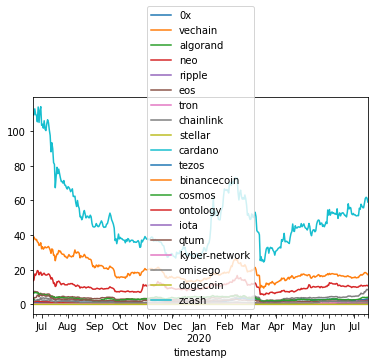

In [136]:

portfolio_dataframe.plot()

In [138]:
study = optuna.create_study(study_name="pm", storage='sqlite:///example.db', direction='maximize')


[I 2020-07-18 13:58:46,080] A new study created with name: pm


In [137]:
study = optuna.delete_study(study_name="pm", storage='sqlite:///example.db')

In [97]:
study = optuna.load_study(study_name="pm", storage='sqlite:///example.db')

In [161]:
def obj(trial):
    window = trial.suggest_int('window', 1, 30)
    rho = trial.suggest_uniform('rho', 0, 1)
    lambd = trial.suggest_uniform('lambd', 0, 1)
    temp = FCORN(window, rho, lambd)
    temp.allocate(portfolio_dataframe, verbose=True)

    data_len, period = portfolio_dataframe.shape[0], 10
    for i in range(0, period):
        time = data_len * i // period
        trial.report(temp.portfolio_return.iloc[time][0], step=time)

    return temp.portfolio_return.iloc[-1][0]

In [159]:
number = 10
study.optimize(obj, n_trials=number)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-18 14:03:50,589] Finished trial#42 with value: 3.2511899769638632 with parameters: {'window': 14, 'rho': -0.21714779943884732, 'lambd': 0.15844981749207654}. Best is trial#22 with value: 4.93065140091774.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-18 14:03:53,053] Finished trial#43 with value: 4.568946915389861 with parameters: {'window': 18, 'rho': -0.14944594407928963, 'lambd': 0.259177653885694}. Best is trial#22 with value: 4.93065140091774.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-18 14:03:55,104] Finished trial#44 with value: 4.563427936451317 with parameters: {'window': 18, 'rho': -0.16429017859093398, 'lambd': 0.2994860309926949}. Best is trial#22 with value: 4.93065140091774.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-18 14:03:57,263] Finished tria

In [162]:
# study_df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
print("Best window parameter: ", study.best_params['window'])
print("Best lambd parameter: ", study.best_params['lambd'])
print("Best rho parameter: ", study.best_params['rho'])
print("Best returns: ", study.best_trial.value)
print("Best trial number: ", study.best_trial.number)

Best window parameter:19
Best lambd parameter:0.8450668567710352
Best rho parameter:0.13363626476380042
Best returns:4.93065140091774
Best trial number:22


In [163]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(title_text="Crpto FCORN for Lambd of [0, 1], Rho of [0, 1], and Window of [1, 30]", yaxis_title_text="Relative Returns")
display(fig)

In [164]:
pm = FCORN(window=study.best_params['window'], rho=study.best_params['rho'], lambd=study.best_params['lambd'])
# mu = EG(update_rule='MU', eta=2)
pm.allocate(asset_prices=portfolio_dataframe, verbose=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [165]:
pm.all_weights.tail(1)

,0x,vechain,algorand,neo,ripple,eos,tron,chainlink,stellar,cardano,tezos,binancecoin,cosmos,ontology,iota,qtum,kyber-network,omisego,dogecoin,zcash
timestamp,,,,,,,,,,,,,,,,,,,,
2020-07-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
current_optimised_weightings = pm.all_weights.tail(1).to_dict('records')
print(current_optimised_weightings)

[{'0x': 0.0, 'vechain': 0.0, 'algorand': 0.0, 'neo': 0.0, 'ripple': 0.0, 'eos': 0.0, 'tron': 0.0, 'chainlink': 0.0, 'stellar': 0.0, 'cardano': 0.0, 'tezos': 1.0, 'binancecoin': 0.0, 'cosmos': 0.0, 'ontology': 0.0, 'iota': 0.0, 'qtum': 0.0, 'kyber-network': 0.0, 'omisego': 0.0, 'dogecoin': 0.0, 'zcash': 0.0}]


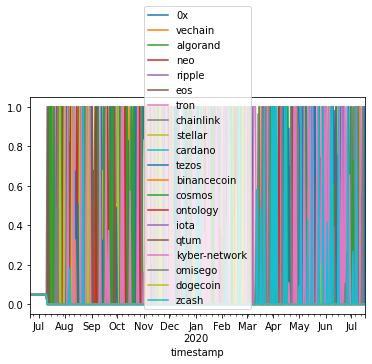

In [167]:
pm.all_weights.plot()

In [168]:
pm.portfolio_return['Returns'].tail()

timestamp
2020-07-13    4.838405
2020-07-14    4.843418
2020-07-15    4.761828
2020-07-16    5.075959
2020-07-17    4.930651
Name: Returns, dtype: float64

In [169]:
fig = go.Figure()
idx = pm.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=pm.portfolio_return['Returns'], name="PM"))
fig.update_layout(title='Pattern Matching Strategy on Crypto', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

In [170]:
pm.weights

array([0.00000000e+00, 0.00000000e+00, 9.71445147e-17, 4.02455846e-16,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.70832444e-17,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 4.19803081e-16])

In [171]:
pm.relative_return[-1]

array([1.02378816, 0.94903164, 1.21429219, 0.97084406, 0.98385835,
       0.98730891, 0.97550568, 0.96509572, 1.07069594, 0.96571314,
       0.97137343, 0.97437925, 1.00363031, 1.00225225, 0.98384132,
       1.00330305, 0.98974384, 0.97045034, 0.96904014, 0.96360662])

In [172]:
pm.asset_prices.tail()

,0x,vechain,algorand,neo,ripple,eos,tron,chainlink,stellar,cardano,tezos,binancecoin,cosmos,ontology,iota,qtum,kyber-network,omisego,dogecoin,zcash
timestamp,,,,,,,,,,,,,,,,,,,,
2020-07-13,0.425720,0.018141,0.278101,10.787088,0.200847,2.615384,0.018162,7.304026,0.094924,0.126878,2.817359,18.282221,4.017787,0.671247,0.251515,2.043960,1.611571,1.537835,0.003639,58.569476
2020-07-14,0.402003,0.018435,0.265993,10.687667,0.198606,2.553199,0.017539,7.168236,0.090259,0.124288,2.898892,18.385027,3.876940,0.676738,0.249067,2.213045,1.527976,1.539428,0.003161,61.190176
2020-07-15,0.395231,0.018463,0.273302,10.841168,0.198871,2.557829,0.017632,8.125226,0.092028,0.132081,2.966638,18.090037,3.954472,0.762674,0.248822,2.351076,1.593608,1.526777,0.003292,61.855655
2020-07-16,0.389933,0.019005,0.289951,11.007032,0.197230,2.535468,0.017580,8.661236,0.094356,0.130447,3.178481,17.602997,4.043584,0.727626,0.245280,2.297758,1.586668,1.519596,0.003089,61.311689
2020-07-17,0.399209,0.018036,0.352086,10.686112,0.194046,2.503290,0.017150,8.358922,0.101026,0.125975,3.087492,17.151995,4.058263,0.729264,0.241317,2.305348,1.570395,1.474692,0.002993,59.080349


Progress: |██████████████████████████████████████████████████| 100.0% Complete
timestamp
2020-07-17    1.343944
Name: Returns, dtype: float64


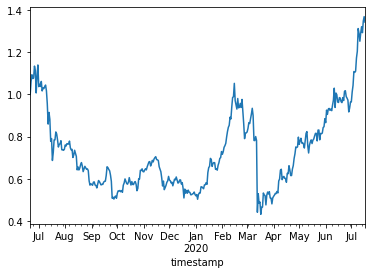

In [173]:
bah = BAH()
bah.allocate(asset_prices=portfolio_dataframe, verbose=True)
print(bah.portfolio_return['Returns'].tail(1))
bah.portfolio_return['Returns'].plot()

In [174]:

fig = go.Figure()
idx = pm.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=pm.portfolio_return['Returns'], name="FCORN"))
fig.update_layout(title='Pattern Matching Strategies on Crypto', xaxis_title='Date', yaxis_title='Relative Returns', yaxis_type="log")
fig.show()

In [175]:
exchange = ccxt.binance({
    "apiKey": binance_api_key,
    "secret": binance_api_secret,
    'enableRateLimit': True,
})
exchange.options['defaultType'] = 'future'

In [206]:
markets = exchange.load_markets(True)
markets.keys()
# ['BTC/USDT', 'ETH/USDT', 'BCH/USDT', 'XRP/USDT', 'EOS/USDT', 'LTC/USDT', 'TRX/USDT', 'ETC/USDT', 'LINK/USDT', 'XLM/USDT', 'ADA/USDT', 'XMR/USDT', 'DASH/USDT', 'ZEC/USDT', 'XTZ/USDT', 'BNB/USDT', 'ATOM/USDT', 'ONT/USDT', 'IOTA/USDT', 'BAT/USDT', 'VET/USDT', 'NEO/USDT', 'QTUM/USDT', 'IOST/USDT', 'THETA/USDT', 'ALGO/USDT', 'ZIL/USDT', 'KNC/USDT', 'ZRX/USDT', 'COMP/USDT', 'OMG/USDT', 'DOGE/USDT']

dict_keys(['BTC/USDT', 'ETH/USDT', 'BCH/USDT', 'XRP/USDT', 'EOS/USDT', 'LTC/USDT', 'TRX/USDT', 'ETC/USDT', 'LINK/USDT', 'XLM/USDT', 'ADA/USDT', 'XMR/USDT', 'DASH/USDT', 'ZEC/USDT', 'XTZ/USDT', 'BNB/USDT', 'ATOM/USDT', 'ONT/USDT', 'IOTA/USDT', 'BAT/USDT', 'VET/USDT', 'NEO/USDT', 'QTUM/USDT', 'IOST/USDT', 'THETA/USDT', 'ALGO/USDT', 'ZIL/USDT', 'KNC/USDT', 'ZRX/USDT', 'COMP/USDT', 'OMG/USDT', 'DOGE/USDT'])

In [177]:
current_balances = exchange.fetch_balance()
current_owned_coins = []

for (key, value) in current_balances.items():
    if (key == 'total'):
        for (coin, balance) in value.items():
            if (balance > 0):
                current_owned_coins.append({ coin: balance })

print(current_owned_coins)

[{'USDT': 54.83400441}]


In [176]:
current_optimised_weightings[0]

{'0x': 0.0,
 'vechain': 0.0,
 'algorand': 0.0,
 'neo': 0.0,
 'ripple': 0.0,
 'eos': 0.0,
 'tron': 0.0,
 'chainlink': 0.0,
 'stellar': 0.0,
 'cardano': 0.0,
 'tezos': 1.0,
 'binancecoin': 0.0,
 'cosmos': 0.0,
 'ontology': 0.0,
 'iota': 0.0,
 'qtum': 0.0,
 'kyber-network': 0.0,
 'omisego': 0.0,
 'dogecoin': 0.0,
 'zcash': 0.0}

In [368]:
current_balances = exchange.fetch_balance()
current_owned_coins = []

for (key, value) in current_balances.items():
    if (key == 'total'):
        for (coin, balance) in value.items():
            if (balance > 0):
                current_owned_coins.append({ coin: balance })

print(current_owned_coins)
orders = []
for (i, coin_data) in enumerate(current_owned_coins):
    for coin in coin_data:
        # print(coin_data)
        # coin
        if coin == 'BTC':
            continue
        if coin == 'VTHO':
            continue
        amount = coin_data[coin]
        converted = float(amount)
        symbol = coin + '/BTC'
        side = 'sell'
        try:
            result = exchange.create_market_order(symbol, side, converted)
            print('SOLD ' + coin + '\n ')
        except ccxt.InsufficientFunds as e:
            print(coin)
            print(amount)
            print('create_order() failed – not enough funds')
            print(e)
        except ccxt.InvalidOrder as e:
            print(coin)
            print(amount)
            print('invalid_order() failed')
            print(e)
            continue
        except Exception as e:
            print(coin)
            print(amount)
            print('create_order() failed')
            print(e)

[{'BTC': 4.041e-05}, {'BNB': 3.42746026}, {'ZRX': 139.96}, {'OMG': 39.86871}, {'LRC': 432.054}, {'ZEC': 1.037853}, {'XRP': 317.664}, {'XLM': 665.572}, {'VTHO': 42.05468331}, {'XTZ': 22.50132}]
SOLD BNB

SOLD ZRX

SOLD OMG

SOLD LRC

SOLD ZEC

SOLD XRP

SOLD XLM

SOLD XTZ



In [369]:
current_balances = exchange.fetch_balance()
current_owned_coins = []

for (key, value) in current_balances.items():
    if (key == 'total'):
        for (coin, balance) in value.items():
            if (balance > 0):
                current_owned_coins.append({ coin: balance })

print('Current owned coins ')
print(current_owned_coins)

btc_balance = current_balances['BTC']['free']
exchange.load_markets()
for (coin, weighting) in current_optimised_weightings[0].items():
    try:
        print('COIN ' + coin)
        print('Weighting ' + str(weighting))
        coin_btc_amount_to_buy = (weighting * btc_balance)
        print('BTC AMOUNT TO BUY ' + str(coin_btc_amount_to_buy))
        ticker = cg.get_coin_ticker_by_id(id=coin, exchange_ids=['binance'])
        ticker = ticker['tickers'][0]['base']
        print(ticker)
        symbol = ticker + '/BTC'
        side = 'buy'
        amount_to_buy = (coin_btc_amount_to_buy / exchange.fetchTicker(symbol).get('last'))
        print('BUYING AMOUNT ' + str(amount_to_buy))
        result = exchange.create_market_order(symbol, side, amount_to_buy)
        print('BOUGHT ' + coin + '\n')
    except ccxt.InsufficientFunds as e:
        print(coin)
        print(amount)
        print('bought() failed – not enough funds')
        try: 
            print('TRYING TO BUY AGAIN  ' + coin + '\n')
            result = exchange.create_market_order(symbol, side, amount * 0.95)
            print(e)
        except Exception as e:
            print(coin)
            print(amount)
            print('bought again() failed')
    except Exception as e:
        print(coin)
        print(amount)
        print('fetch() failed')
        print(e)

Current owned coins
[{'BTC': 0.05444053}, {'BNB': 0.00012845}, {'ZRX': 0.96}, {'OMG': 0.00871}, {'LRC': 0.054}, {'ZEC': 0.000853}, {'XRP': 0.664}, {'XLM': 0.572}, {'VTHO': 42.05468331}, {'XTZ': 0.00132}]
COIN omisego
Weighting 0.12851430950395515
BTC AMOUNT TO BUY 0.006996387121979355
OMG
BUYING AMOUNT 41.66996499094316
BOUGHT omisego

COIN stellar
Weighting 0.12274444062073216
BTC AMOUNT TO BUY 0.006682272401946188
XLM
BUYING AMOUNT 652.5656642525573
BOUGHT stellar

COIN 0x
Weighting 0.12506209372872476
BTC AMOUNT TO BUY 0.006808446665501453
ZRX
BUYING AMOUNT 153.8284379914472
BOUGHT 0x

COIN ripple
Weighting 0.11433645744006321
BTC AMOUNT TO BUY 0.0062245373413594846
XRP
BUYING AMOUNT 284.2254493771454
BOUGHT ripple

COIN tezos
Weighting 0.12735491016835623
BTC AMOUNT TO BUY 0.006933268807667703
XTZ
BUYING AMOUNT 20.883339782131635
BOUGHT tezos

COIN loopring
Weighting 0.13722760621847668
BTC AMOUNT TO BUY 0.007470743613165166
LRC
BUYING AMOUNT 501.7289196215693
BOUGHT loopring

COIN